<p><font size="7" color='grey'> <b>
Anwendung Generativer KI
</b></font> </br></p>

<p><font size="6" color='grey'> <b>
Chat und Memory
</b></font> </br></p>


---

<a target="_blank" href="https://colab.research.google.com/github/ralf-42/GenAI/blob/main/01%20ipynb/M00_Prolog.ipynb">
  <img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/>
</a>

In [ ]:
#@title
#@markdown   <p><font size="4" color='green'>  Colab-Umfeld</font> </br></p>
# Installierte Python Version
import sys
print(f"Python Version: ",sys.version)
# Installierte LangChain Bibliotheken
print()
print("Installierte LangChain Bibliotheken:")
!pip list | grep '^langchain'
# Unterdrückt die "DeprecationWarning" von LangChain für die Memory-Funktionden
import warnings
warnings.filterwarnings("ignore", category=DeprecationWarning)
warnings.filterwarnings("ignore", category=UserWarning, module="langsmith.client")
warnings.filterwarnings("ignore", category=DeprecationWarning, module="langchain")

In [ ]:
#@title
#@markdown   <p><font size="4" color='green'>  SetUp API-Keys (setup_api_keys)</font> </br></p>
def setup_api_keys():
    """Konfiguriert alle benötigten API-Keys aus Google Colab userdata"""
    from google.colab import userdata
    import os
    from os import environ

    # Dictionary der benötigten API-Keys
    keys = {
        'OPENAI_API_KEY': 'OPENAI_API_KEY',
        'HF_TOKEN': 'HF_TOKEN',
        # Weitere Keys bei Bedarf
    }

    # Keys in Umgebungsvariablen setzen
    for env_var, key_name in keys.items():
        environ[env_var] = userdata.get(key_name)

    return {k: environ[k] for k in keys.keys()}

# Verwendung
all_keys = setup_api_keys()
# Bei Bedarf einzelne Keys direkt zugreifen
# WEATHER_API_KEY = all_keys['WEATHER_API_KEY']

# **1 <font color='orange'>|</font> Conversation**
---

Große Sprachmodelle (LLMs) ermöglichen eine natürliche Interaktion ähnlich menschlicher Gespräche. Sie sind in der Lage, auf vorherige Informationen innerhalb eines Dialogs Bezug zu nehmen. In diesem Modul wird die Verwaltung des Speichers eines LLMs untersucht. Da der interne Kontextpuffer (derzeit) begrenzt ist, sind Logiken erforderlich, um den Chat-Verlauf zu speichern. Eine solche Lösung bietet LangChain, das Konversationsverläufe in jede neue Anfrage integriert. Dazu wird ein fortlaufendes Transkript aller Interaktionen geführt, das sowohl Eingaben als auch Antworten enthält. Dieses Transkript wird bei jeder neuen Anfrage erneut an das LLM übermittelt, sodass es basierend auf dem bisherigen Dialog eine passende Antwort generieren kann und der interaktive Austausch fortgesetzt wird.

<p><font color='black' size="5">
Modellaufbau
</font></p>

Im vorliegenden Code wird ein Chatbot-Modell schrittweise aufgebaut. Der Modellaufbau ist modular und kann als `template` für nachfolgende Konversationsmodelle verwendet werden.

Diese strukturierte Aufteilung macht das Modell robust, wartbar und erweiterbar für verschiedene Anwendungsfälle im Bereich der Konversations-KI.



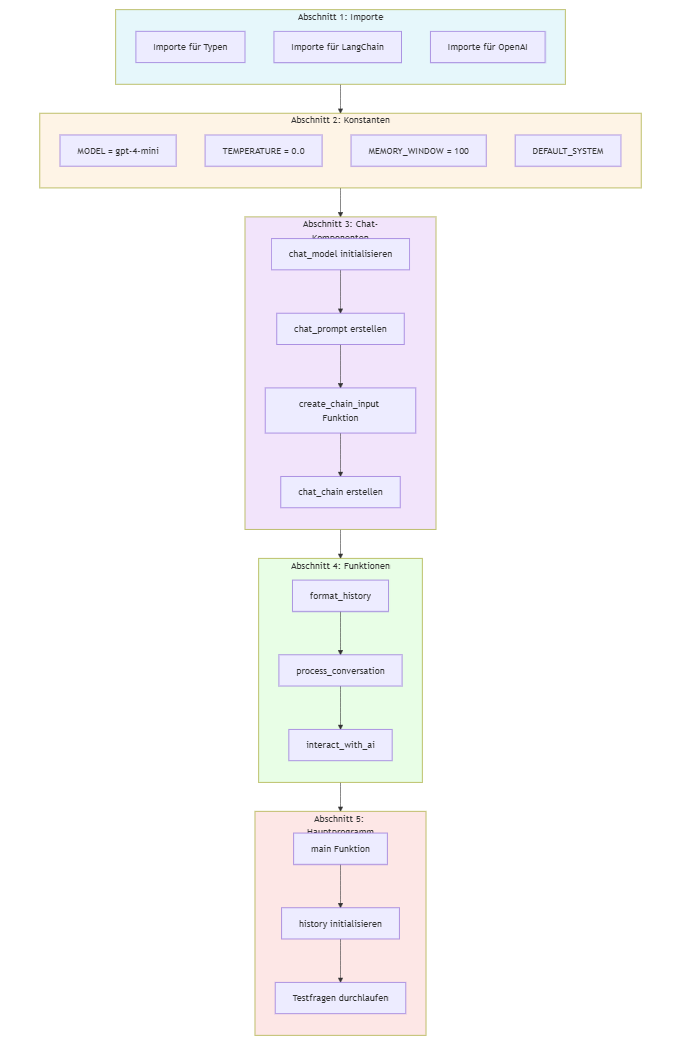

In [ ]:
# Abschnitt 0: Installation und API-Key
!uv pip install --system --upgrade --quiet langchain_community langchain_openai

In [ ]:
# Abschnitt 1: Importe
from IPython.display import display, Markdown

from langchain_core.messages import SystemMessage, HumanMessage, AIMessage
from langchain_core.prompts import ChatPromptTemplate, MessagesPlaceholder
from langchain_openai import ChatOpenAI
from langchain_core.output_parsers import StrOutputParser
from langchain_core.runnables import RunnablePassthrough, RunnableLambda

# Abschnitt 2: Konstanten definieren
MODEL = "gpt-4o-mini"
TEMPERATURE = 0.0
MEMORY_WINDOW = 100 # hoher Wert, praktisch keine Beschränkung der Anzahl

DEFAULT_SYSTEM = """
Du bist ein kompetenter KI-Assistent mit breitem Fachwissen.

Deine Antworten sind:
- Klar strukturiert und mit Markdown formatiert
- Praxisorientiert und direkt umsetzbar
- Basierend auf aktuellem Kenntnisstand
- Mit passenden Beispielen versehen
- In verständlicher Sprache formuliert

Bei deiner Arbeit:
- Analysierst du Fragen sorgfältig
- Gibst präzise und relevante Antworten
- Erkennst den Kontext der Anfrage
- Bietest bei Bedarf weiterführende Informationen
- Bleibst sachlich und neutral

Formatiere alle Antworten in Markdown für optimale Lesbarkeit.
"""

# Abschnitt 3: Chat-Komponenten initialisieren
llm = ChatOpenAI(
    temperature=TEMPERATURE,
    model=MODEL
)

chat_prompt = ChatPromptTemplate.from_messages([
    ("system", "{system_prompt}"),
    MessagesPlaceholder(variable_name="chat_history"),
    ("human", "{question}")
])

def create_chain_input(input_dict: dict[str]) -> dict[str]:
    """Erstellt den Input für die Chain mit History."""
    return {
        "question": input_dict["question"],
        "system_prompt": DEFAULT_SYSTEM,
        "chat_history": input_dict["history"]
    }

# LCEL Chain mit History erstellen
chat_chain = (
    RunnableLambda(create_chain_input)
    | chat_prompt
    | llm
    | StrOutputParser()
)

# Abschnitt 4: Funktionen definieren
def format_history(history: list) -> list:
    """  Formatiert den Konversationsverlauf. """
    return history[-MEMORY_WINDOW:]

def process_conversation(question: str, history: list) -> list:
    """ Verarbeitet eine Konversation. """
    # Nutzereingabe anzeigen
    print(f"\n🧑‍🦱 Mensch: {question}")

    # Antwort mit History generieren
    response = chat_chain.invoke({
        "question": question,
        "history": format_history(history)
    })

    # Antwort anzeigen
    print("\n🤖 KI: ", end="")
    display(Markdown(response))
    print()

    # Konversationsverlauf aktualisieren
    return history + [
        HumanMessage(content=question),
        AIMessage(content=response)
    ]

def interact_with_ai(question: str, history: list) -> list:
    """ Führt eine einzelne Interaktion mit der KI durch. """
    return process_conversation(question, history)

# Abschnitt 5: Hauptprogramm
# Konversationsverlauf initialisieren
history = [SystemMessage(content=DEFAULT_SYSTEM)]

# Testfragen
test_questions = [
    "Mein Lieblingsgericht ist Lasagne. Antworte kurz.",
    "Wie viele Tage hat eine Woche? Antworte kurz.",
    "Wie viele Tage hat ein Monat? Antworte kurz.",
    "Wie viele Tage hat ein Jahr? Antworte kurz.",
    "Was ist mein Lieblingsgericht?"
]

# Testfragen durchlaufen
for question in test_questions:
    history = interact_with_ai(question, history)

<p><font color='black' size="5">
Memory-Klassen
</font></p>


Gedächtnismodelle spielen eine zentrale Rolle in modernen Conversational Agents und Chatbots. Sie ermöglichen es, den bisherigen Gesprächsverlauf intelligent zu speichern, zu verarbeiten und als Kontext für zukünftige Antworten zu nutzen. Dies ist aus mehreren Gründen von großer Bedeutung:

+ **Kontextualität und Kohärenz:**
Damit ein Chatbot oder Sprachassistent sinnvolle und konsistente Antworten liefern kann, muss er den Verlauf der Unterhaltung berücksichtigen. Gedächtnismodelle helfen dabei, relevante Informationen aus früheren Interaktionen bereitzustellen und so den Dialog kontextbezogen fortzuführen.

+ **Effiziente Nutzung von Ressourcen:**
Gerade bei großen Sprachmodellen gibt es oft Einschränkungen hinsichtlich der maximal verarbeitbaren Token. Modelle wie das ConversationTokenBufferMemory sorgen dafür, dass der an das Modell übergebene Kontext nicht die Token-Grenzen sprengt, indem sie dynamisch nur die wichtigsten Teile der Unterhaltung einbeziehen.

+ **Langfristige Interaktion:**
Für Anwendungen, die über längere Zeiträume oder in mehreren Sitzungen hinweg interagieren – wie etwa Kundensupport-Chatbots – ist es essenziell, den gesamten Gesprächsverlauf verfügbar zu haben. Persisting Memory ermöglicht es, alle Interaktionen dauerhaft zu speichern, sodass auch bei neuen Sitzungen auf vergangene Konversationen zurückgegriffen werden kann.

+ **Zusammenfassungen langer Gespräche:**
In lang andauernden Unterhaltungen kann es passieren, dass der gesamte Verlauf zu umfangreich wird. Mit dem ConversationSummaryMemory lassen sich ältere Interaktionen in prägnante Zusammenfassungen verwandeln, die den wesentlichen Inhalt beibehalten, ohne den Kontext zu überladen.


Zusammenfassend lässt sich sagen, dass die Auswahl der geeigneten Memory-Klasse von der Länge der Konversation, der Wichtigkeit des Kontextes und den verfügbaren Rechenressourcen abhängt

# **2 <font color='orange'>|</font> Kontextualität**
---



Die Systemeingabeaufforderung (Customer Instruction, System Prompt) kann genutzt werden, um die Unterhaltung auf ein bestimmtes Thema zu fokussieren. In diesem Fall wird ein einfacher Agent eingerichtet, der ausschließlich über **Programmierung** spricht.

In [ ]:
# Abschnitt 1: Importe
from IPython.display import display, Markdown

from langchain_core.messages import SystemMessage, HumanMessage, AIMessage
from langchain_core.prompts import ChatPromptTemplate, MessagesPlaceholder
from langchain_openai import ChatOpenAI
from langchain_core.output_parsers import StrOutputParser
from langchain_core.runnables import RunnablePassthrough, RunnableLambda

# Abschnitt 3: Konstanten definieren
MODEL = "gpt-4o-mini"
TEMPERATURE = 0.0
MEMORY_WINDOW = 100 # hoher Wert, praktisch keine Beschränkung der Anzahl

DEFAULT_SYSTEM = """
Du bist ein kompetenter Programmierer und beantwortest nur Fragen zur Programmierung.
Fragen zu anderen Themen ausser der Programmierung werden nicht beantwortet.

Deine Antworten sind:
- Klar strukturiert und mit Markdown formatiert
- Praxisorientiert und direkt umsetzbar
- Basierend auf aktuellem Kenntnisstand
- Mit passenden Beispielen versehen
- In verständlicher Sprache formuliert

Bei deiner Arbeit:
- Analysierst du Fragen sorgfältig
- Gibst präzise und relevante Antworten
- Erkennst den Kontext der Anfrage
- Bietest bei Bedarf weiterführende Informationen
- Bleibst sachlich und neutral

Formatiere alle Antworten in Markdown für optimale Lesbarkeit.
"""

# Abschnitt 3: Chat-Komponenten initialisieren
llm = ChatOpenAI(
    temperature=TEMPERATURE,
    model=MODEL
)

chat_prompt = ChatPromptTemplate.from_messages([
    ("system", "{system_prompt}"),
    MessagesPlaceholder(variable_name="chat_history"),
    ("human", "{question}")
])

def create_chain_input(input_dict: dict[str]) -> dict[str]:
    """Erstellt den Input für die Chain mit History."""
    return {
        "question": input_dict["question"],
        "system_prompt": DEFAULT_SYSTEM,
        "chat_history": input_dict["history"]
    }

# LCEL Chain mit History erstellen
chat_chain = (
    RunnableLambda(create_chain_input)
    | chat_prompt
    | llm
    | StrOutputParser()
)

# Abschnitt 5: Funktionen definieren
def format_history(history: list) -> list:
    """ Formatiert den Konversationsverlauf. """
    return history[-MEMORY_WINDOW:]

def process_conversation(question: str, history: list) -> list:
    """ Verarbeitet eine Konversation. """
    # Nutzereingabe anzeigen
    print(f"\n🧑‍🦱 Mensch: {question}")

    # Antwort mit History generieren
    response = chat_chain.invoke({
        "question": question,
        "history": format_history(history)
    })

    # Antwort anzeigen
    print("\n🤖 KI: ", end="")
    display(Markdown(response))
    print()

    # Konversationsverlauf aktualisieren
    return history + [
        HumanMessage(content=question),
        AIMessage(content=response)
    ]

def interact_with_ai(question: str, history: list) -> list:
    """ Führt eine einzelne Interaktion mit der KI durch. """
    return process_conversation(question, history)

# Abschnitt 6: Hauptprogramm
# Konversationsverlauf initialisieren
history = [SystemMessage(content=DEFAULT_SYSTEM)]

# Testfragen
test_questions = [
    "Nenne die 5 wichtigesten Programmiersprachen. Antworte kurz.",
    "Welche Kontrollstrukturen kennt Python? Antworte kurz.",
    "Wie viele Tage hat ein Monat? Antworte kurz.",
    "Wie viele Tage hat ein Jahr? Antworte kurz."
]

# Testfragen durchlaufen
for question in test_questions:
    history = interact_with_ai(question, history)


# **3 <font color='orange'>|</font> Nachrichten-Limit**
---

**ConversationBufferWindowMemory**

Ein gängiges Verfahren beim Aufbau eines LLM-Chat-Clients besteht darin, ein fortlaufendes Protokoll der Konversation zwischen Mensch und KI zu speichern. Dabei wird jede menschliche Eingabe hinzugefügt, woraufhin die KI darauf reagiert. Dieser Prozess setzt sich fort, solange die Unterhaltung aktiv ist.


Beim `ConversationBufferWindowMemory` wird ein Fenster (z. B. die letzten 3 Nachrichten) als Gedächtnis für das LLM verwendet. Das ist praktisch, wenn nur ein begrenzter Kontext relevant ist.

Der Parameter k in ConversationBufferWindowMemory steuert, welche Nachrichten (bzw. Runden) dem LLM als Kontext übergeben werden – nicht aber, welche Nachrichten tatsächlich im zugrunde liegenden Chatverlauf (also in chat_memory.messages) gespeichert sind.

**Anwendung:**    
Wenn der Wert *k = 3* gesetzt wird, bleiben zwar alle bisherigen Nachrichten im Speicher erhalten, jedoch werden beim nächsten Aufruf nur die letzten drei Gesprächsrunden an das LLM weitergegeben. Das entspricht insgesamt sechs Nachrichten - jeweils drei von der Nutzereingabe und drei von der KI-Antwort.

In [ ]:
# Abschnitt 1: Importe
from langchain_openai import ChatOpenAI
from langchain.prompts import ChatPromptTemplate, MessagesPlaceholder
from langchain.memory import ConversationBufferWindowMemory
from langchain.schema import SystemMessage, HumanMessage, AIMessage
from IPython.display import display, Markdown
from operator import itemgetter

# Abschnitt 2: Konstanten
MODEL = "gpt-4o-mini"
TEMPERATURE = 0.0
DEFAULT_SYSTEM = "Du bist ein hilfsbereiter KI-Assistent."
MAX_HISTORY = 3

# Abschnitt 3: Chat-Komponenten initialisieren
llm = ChatOpenAI(temperature=TEMPERATURE, model=MODEL)

# Memory mit k=3 für Fenstergröße
memory = ConversationBufferWindowMemory(
    k=MAX_HISTORY,
    return_messages=True,
    memory_key="history"
)

prompt = ChatPromptTemplate.from_messages([
    ("system", DEFAULT_SYSTEM),
    MessagesPlaceholder(variable_name="history"),
    ("human", "{input}")
])

def get_chat_history(input_dict: dict) -> dict:
    """Lädt die Chat-Historie aus dem Memory."""
    memory_vars = memory.load_memory_variables({})
    return {
        "history": memory_vars["history"],
        "input": input_dict["input"]
    }

# Chain mit Pipe erstellen
chain = get_chat_history | prompt | llm

# Abschnitt 4: Funktionen definieren
def process_response(response, question):
    """Verarbeitet die KI-Antwort."""
    response_text = response.content if isinstance(response, AIMessage) else str(response)
    display(Markdown(response_text))

    # Speichere die Konversation im Memory
    memory.save_context({"input": question}, {"output": response_text})

    return response_text

def interact_with_ai(question):
    """Führt eine einzelne Interaktion mit der KI durch."""
    print(f"\n🧑‍🦱 Mensch: {question}")
    print("\n🤖 KI: ", end="")

    response = chain.invoke({"input": question})
    return process_response(response, question)

# Abschnitt 5: Hauptprogramm
TEST_QUESTIONS = [
    "Mein Lieblingsgericht ist Lasagne. Antworte kurz.",
    "Wie viele Tage hat eine Woche? Antworte kurz.",
    "Wie viele Tage hat ein Monat? Antworte kurz.",
    "Wie viele Tage hat ein Jahr? Antworte kurz.",
    "Was ist mein Lieblingsgericht?"
]

# Interaktion durchführen
for question in TEST_QUESTIONS:
    interact_with_ai(question)

<p><font color='black' size="5">
Untersuchung des Gesprächsgedächtnisses
</font></p>

Es ist möglich, direkt auf den von LangChain verwalteten Chat-Speicher zuzugreifen und den aktuellen Konversationsverlauf mit dem LLM einzusehen.

In [ ]:
print("\nGespeicherter Kontext:")
memory_ai = memory.load_memory_variables({})["history"]
for i in range(len(memory_ai)):
    print(memory_ai[i].content)

<p><font color='blue' size="4">
Version mit benutzerdefinierter Memory-Funktion & LCEL
</font></p>

In [ ]:
#@title
#@markdown   <p><font size="4" color='blue'>  Code Version </font> </br></p>
# Abschnitt 1: Importe
from IPython.display import display, Markdown

from langchain_core.runnables import RunnableLambda, RunnableMap
from langchain_openai import ChatOpenAI
from langchain_core.prompts import PromptTemplate
from langchain.schema import AIMessage

# Abschnitt 2: Konstanten definieren
MODEL = "gpt-4o-mini"
MAX_HISTORY = 3  # Maximale Anzahl an gespeicherten Konversationsbeiträgen

DEFAULT_SYSTEM = """Du bist ein kompetenter KI-Assistent mit breitem Fachwissen.

Deine Antworten sind:
- Klar strukturiert und mit Markdown formatiert
- Praxisorientiert und direkt umsetzbar
- Basierend auf aktuellem Kenntnisstand
- Mit passenden Beispielen versehen
- In verständlicher Sprache formuliert

Aktuelle Konversation:
{history}
Mensch: {input}
KI:"""

# Abschnitt 3: Funktionen
# Speicher für Konversationshistorie manuell verwalten
conversation_history: list[str] = []

def update_memory(question: str, response: str) -> list[str]:
    """Fügt neue Konversationsbeiträge zur Historie hinzu."""
    global conversation_history
    conversation_history.append(f"Mensch: {question}\nKI: {response}")

    # Begrenze die Historie auf die letzten N Einträge
    if len(conversation_history) > MAX_HISTORY:
        conversation_history = conversation_history[-MAX_HISTORY:]

    return conversation_history

def format_history(history: list[str]) -> str:
    """Formatiert die Historie für die Eingabe an das Modell."""
    return "\n".join(history)

# Interaktionen mit dem Modell
def interact_with_ai(question):
    """Führt eine einzelne Interaktion mit der KI durch."""
    print(f"\n🧑‍🦱 Mensch: {question}")
    print("\n🤖 KI: ", end="")

    response = chain.invoke({"input": question})

    # Antwort extrahieren
    response_text = response.content if isinstance(response, AIMessage) else str(response)
    display(Markdown(response_text))

    # Speicher aktualisieren
    update_memory(question, response_text)

    return response_text

# Abschnitt 4: LLM und LCEL-Chain initialisieren
llm = ChatOpenAI(
    model_name=MODEL,
    temperature=0.0
)

prompt = PromptTemplate(
    input_variables=["history", "input"],
    template=DEFAULT_SYSTEM
)

# RunnableMap für Input-Transformation
prepare_input = RunnableLambda(lambda x: {
    "history": format_history(conversation_history),
    "input": x["input"]
})

# LCEL-Chain erstellen
chain = prepare_input | prompt | llm

# Beispielinteraktionen
TEST_QUESTIONS = [
    "Mein Lieblingsgericht ist Lasagne. Antworte kurz.",
    "Wie viele Tage hat eine Woche? Antworte kurz.",
    "Wie viele Tage hat ein Monat? Antworte kurz.",
    "Wie viele Tage hat ein Jahr? Antworte kurz.",
    "Was ist mein Lieblingsgericht?"
]

# Interaktion durchführen
for question in TEST_QUESTIONS:
    interact_with_ai(question)

In [ ]:
#@title
#@markdown   <p><font size="4" color='blue'> Gesprächsgedächtnis </font> </br></p>
print("\nGespeicherter Kontext:")
memory_ai = memory.load_memory_variables({})["history"]
for msg in memory_ai:
    # print(memory_ai[i].content)
    print(f"\nTyp: {msg.type}")
    print(f"Inhalt: {msg.content}")


# **4 <font color='orange'>|</font> Token-Limit**
---


**ConversationTokenBufferMemory**

Bisher wurde gesehen, dass die letzten **k** ausgetauschten Nachrichten zwischen der KI und dem Nutzer speichert. Eine wesentliche Einschränkung dieser Methode liegt darin, dass die Anzahl der gespeicherten Zeilen nicht die tatsächlich verfügbare Speicherkapazität des zugrunde liegenden LLM berücksichtigt. Dieses begrenzt den Speicher anhand der Kontextfenstergröße, die in Tokens und nicht in Zeilen bemessen wird.

In diesem Abschnitt wird die Nutzung von **ConversationTokenBufferMemory** erläutert. Dieses funktioniert ähnlich wie bei den Nachrichten, jedoch wird hier die Anzahl der gespeicherten Tokens anstelle der Nachrichten festgelegt. Dadurch lässt sich gezielt bestimmen, welcher Anteil des verfügbaren Kontextfensters für den Speicher genutzt wird. Dabei ist zu beachten, dass das Kontextfenster nicht nur den Verlauf der Unterhaltung umfasst, sondern auch die Eingabeaufforderung sowie die generierte Ausgabe des LLM. Daher ist eine vorausschauende Planung erforderlich.

Der nachfolgende Code demonstriert, wie **ConversationTokenBufferMemory** als Speichermodul in einer Chat-Kette implementiert wird.

In [ ]:
# Abschnitt 1: Importe
from IPython.display import display, Markdown
from langchain.chains import ConversationChain
from langchain.memory import ConversationTokenBufferMemory
from langchain_openai import ChatOpenAI
from langchain_core.prompts import PromptTemplate
from langchain.schema import AIMessage

# Abschnitt 2: Konstanten definieren
MODEL = "gpt-4o-mini"
MAX_TOKEN_LIMIT = 1024
DEFAULT_SYSTEM = """Du bist ein kompetenter KI-Assistent mit breitem Fachwissen.

Deine Antworten sind:
- Klar strukturiert und mit Markdown formatiert
- Praxisorientiert und direkt umsetzbar
- Basierend auf aktuellem Kenntnisstand
- Mit passenden Beispielen versehen
- In verständlicher Sprache formuliert

Aktuelle Konversation:
{history}
Mensch: {input}
KI:"""

# Abschnitt 3: Funktionen definieren
def process_response(response, question):
    """Verarbeitet die KI-Antwort."""
    if isinstance(response, dict) and "response" in response:
        response_text = response["response"]
    elif isinstance(response, AIMessage):
        response_text = response.content
    else:
        response_text = str(response)

    display(Markdown(response_text))

    # Speichere die Konversation im Memory
    memory.save_context({"input": question}, {"output": response_text})

    return response_text

def interact_with_ai(question):
    """Führt eine einzelne Interaktion mit der KI durch."""
    print(f"\n🧑‍🦱 Mensch: {question}")
    print("\n🤖 KI: ", end="")

    response = chain.invoke({"input": question})
    return process_response(response, question)

# Abschnitt 4: LLM und Kette initialisieren
llm = ChatOpenAI(
    model_name=MODEL,
    temperature=0.0
)

memory = ConversationTokenBufferMemory(
    llm=llm,
    max_token_limit=MAX_TOKEN_LIMIT,
    return_messages=True
)

# Prompt Template erstellen
prompt = PromptTemplate(
    input_variables=["history", "input"],
    template=DEFAULT_SYSTEM
)

# Conversation Chain erstellen
chain = ConversationChain(
    llm=llm,
    memory=memory,
    prompt=prompt,
    verbose=False
)

# Abschnitt 5: Interaktionen mit dem Modell
interact_with_ai("Mein Name ist Ralf")
interact_with_ai("Warum ist der Himmel blau?")
interact_with_ai("Und warum ist er manchmal rot?")
interact_with_ai("Wie ist mein Name?")

<p><font color='black' size="5">
Untersuchung des Gesprächsgedächtnisses
</font></p>

In [ ]:
display(Markdown("## ✨ Gespeicherter Kontext:"))
memory_ai = memory.load_memory_variables({})["history"]
for msg in memory_ai:
    display(Markdown(f"**Typ:** {msg.type}"))
    display(Markdown(f"**Inhalt:** {msg.content}"))

# **5 <font color='orange'>|</font> Chat-Zusammenfassung**
---

**ConversationSummaryMemor**

ConversationSummaryMemory speichert und aktualisiert eine Zusammenfassung der Konversation, anstatt ältere Chatverläufe zu vergessen. Dies ermöglicht die Bewahrung wichtiger Informationen und hält den Speicher effizient.

Das Modell sorgt dafür, dass der Speicherpuffer überschaubar bleibt, um Leistungsprobleme zu vermeiden. Der bereitgestellte Code demonstriert die Einrichtung eines Konversations-KI-Systems mit LangChain, wobei der Fokus auf der präzisen Erinnerung an vorherige Interaktionen liegt.

Dieses System ist darauf ausgelegt, eine reaktionsschnelle und kontextbezogene Konversations-KI bereitzustellen. Dabei wird vermieden, dass zu viele Informationen aus der Vergangenheit gespeichert werden, um die Relevanz und Effizienz in laufenden Interaktionen zu gewährleisten.

In [ ]:
# Abschnitt 1: Importe
from IPython.display import display, Markdown

from langchain_core.prompts import ChatPromptTemplate, MessagesPlaceholder
from langchain_core.messages import HumanMessage, AIMessage
from langchain_openai import ChatOpenAI
from langchain.memory import ConversationSummaryMemory
from langchain_core.runnables import RunnablePassthrough

# Abschnitt 2: Konstanten definieren
MODEL = "gpt-4o-mini"

# Abschnitt 3: Funktionen definieren
def process_response(response, question):
    """Verarbeitet die KI-Antwort."""
    if isinstance(response, dict) and "response" in response:
        response_text = response["response"]
    elif isinstance(response, AIMessage):
        response_text = response.content
    else:
        response_text = str(response)

    display(Markdown(response_text))

    # Speichere die Konversation im Memory
    memory.save_context({"input": question}, {"output": response_text})

    return response_text

def interact_with_ai(question):
    """Führt eine einzelne Interaktion mit der KI durch."""
    print(f"\n🧑‍🦱 Mensch: {question}")
    print("\n🤖 KI: ", end="")

    response = chain.invoke({"input": question})
    return process_response(response, question)

# Abschnitt 4: Chain und Memory initialisieren
# LLM initialisieren
llm = ChatOpenAI(
    temperature=0,
    model_name=MODEL
)

# Memory initialisieren
memory = ConversationSummaryMemory(
    llm=llm,
    return_messages=True,
    max_token_limit=2000
)

# Prompt Template erstellen
prompt = ChatPromptTemplate.from_messages([
    ("system", "Du bist ein hilfreicher Assistent. Nutze vorherige Konversationen für kontextbezogene Antworten."),
    MessagesPlaceholder(variable_name="history"),
    ("human", "{input}")
])

# Chain erstellen
chain = (
    RunnablePassthrough.assign(
        history=lambda x: memory.load_memory_variables({})["history"]
    )
    | prompt
    | llm
)

# Abschnitt 5: Beispiel-Interaktionen
conversations = [
    "Mein Name ist Ralf",
    "Warum ist der Himmel blau?",
    "Und warum ist er manchmal rot?",
    "Wie ist mein Name?"
]

# Abschnitt 6: Nachrichten verarbeiten und Ergebnisse anzeigen
for user_input in conversations:
    interact_with_ai(user_input)

<p><font color='black' size="5">
Untersuchung des Gesprächsgedächtnisses
</font></p>

In [ ]:
print("Aktuelle Zusammenfassung:")
summary_ai = memory.load_memory_variables({})["history"]
print(summary_ai[0].content)

<p><font color='blue' size="4">
Version Summary mit BaseMemory
</font></p>

In [ ]:
#@title
#@markdown   <p><font size="4" color='blue'>  Code</font> </br></p>
from IPython.display import display, Markdown

from langchain_core.memory import BaseMemory
from langchain_core.messages import BaseMessage
from langchain_openai import ChatOpenAI
from langchain.schema import SystemMessage

from pydantic import Field  # Pydantic für Feld-Deklarationen

class SummarizedMemory(BaseMemory):
    """Speichert eine zusammengefasste Version des Gesprächsverlaufs."""

    llm: ChatOpenAI = Field(...)  # LLM muss als Feld deklariert sein
    summary_limit: int = Field(default=5)  # Anzahl der Nachrichten vor Zusammenfassung
    chat_memory: list[str] = Field(default_factory=list)  # Verlauf als Liste von Strings
    summary: str = Field(default="")  # Gespeicherte Zusammenfassung

    def summarize_chat(self):
        """Erstellt eine Zusammenfassung des bisherigen Gesprächsverlaufs."""
        if not self.chat_memory:
            return self.summary  # Falls keine Nachrichten vorliegen, Rückgabe der bisherigen Zusammenfassung

        prompt = "Erstelle eine kurze Zusammenfassung dieses Gesprächs:\n\n" + "\n".join(self.chat_memory)
        summary_response = self.llm.invoke([SystemMessage(content=prompt)])
        return summary_response.content

    def save_context(self, inputs: dict, outputs: dict):
        """Speichert Nutzer- und KI-Nachrichten und erstellt eine Zusammenfassung, wenn nötig."""
        self.chat_memory.append(f"Nutzer: {inputs['input']}")
        self.chat_memory.append(f"KI: {outputs['output']}")

        # Falls die Nachrichtenanzahl überschritten wird, erstelle eine Zusammenfassung
        if len(self.chat_memory) > self.summary_limit:
            self.summary = self.summarize_chat()
            self.chat_memory = [f"Zusammenfassung: {self.summary}"]

    def load_memory_variables(self, inputs: dict) -> dict:
        """Gibt die gespeicherte Zusammenfassung oder den aktuellen Gesprächsverlauf zurück."""
        return {"history": self.summary if self.summary else "\n".join(self.chat_memory)}

    def clear(self):
        """Löscht den Gesprächsverlauf und die Zusammenfassung."""
        self.chat_memory = []
        self.summary = ""

    @property
    def memory_variables(self):
        """Gibt an, welche Variablen von dieser Memory-Instanz gespeichert werden."""
        return ["history"]

# OpenAI LLM initialisieren
llm = ChatOpenAI(model="gpt-4o-mini", temperature=0)

# Memory mit LLM zur Zusammenfassung nutzen
memory = SummarizedMemory(llm=llm, summary_limit=5)

# Beispiel: Speichern von Konversationen
memory.save_context({"input": "Hallo, wie geht es dir?"}, {"output": "Mir geht es gut, danke!"})
memory.save_context({"input": "Was ist die Hauptstadt von Frankreich?"}, {"output": "Paris."})
memory.save_context({"input": "Was kannst du mir über den Eiffelturm sagen?"}, {"output": "Der Eiffelturm wurde 1889 erbaut."})
memory.save_context({"input": "Wie hoch ist der Eiffelturm?"}, {"output": "Er ist 330 Meter hoch."})
memory.save_context({"input": "Wer hat ihn entworfen?"}, {"output": "Gustave Eiffel war der leitende Ingenieur."})

# Speicherinhalt abrufen (falls 5 Nachrichten überschritten wurden, wird eine Zusammenfassung erstellt)
print(memory.load_memory_variables({}))

# Gesprächsverlauf löschen
memory.clear()
print(memory.load_memory_variables({}))  # Sollte nun leer sein

# **6 <font color='orange'>|</font> Persistenter Speicher**
---

Die Möglichkeit eines ChatBots, sich an vorherige Unterhaltungen zu erinnern, spielt eine zentrale Rolle für eine flüssige und konsistente Kommunikation. Ein **persistenter Speicher** erlaubt es, Gesprächsdaten über mehrere Sitzungen hinweg zu sichern und wiederzuverwenden. Dadurch kann der ChatBot nicht nur den Kontext besser erfassen, sondern auch langfristige Nutzerpräferenzen berücksichtigen.  

Dieses Kapitel untersucht verschiedene Speicherlösungen für ChatBots und deren effiziente Integration. Dabei werden unterschiedliche Methoden analysiert – von einfachen Dateisystemen über relationale und NoSQL-Datenbanken bis hin zu spezialisierten Speichern für große Sprachmodelle. Zudem wird aufgezeigt, wie gespeicherte Informationen verwaltet, aktualisiert und geschützt werden, um eine ausgewogene Kombination aus Leistungsfähigkeit, Datenschutz und Benutzerfreundlichkeit zu gewährleisten.  

Die Implementierung eines dauerhaften Speichers ermöglicht es einem ChatBot, nicht nur die Interaktion mit Nutzern zu verbessern, sondern auch personalisierte, kontextbezogene und langfristig relevante Dialoge zu führen.

Für die nachfolgende Version wird die Kasse **BaseMemory** für einen persistenten Chat verwendet. Der Chat-Verlauf wird in einer json-Datei gespeichert. Diese Klasse dient als abstrakte Basisklasse, von der spezifische Memory-Implementierungen abgeleitet werden, um Kontexte und Zwischenergebnisse in den Arbeitsabläufen (Chains) zu speichern und wiederzuverwenden.

<p><font color='blue' size="4">
Version: kompletter Chat m. BaseMemory
</font></p>

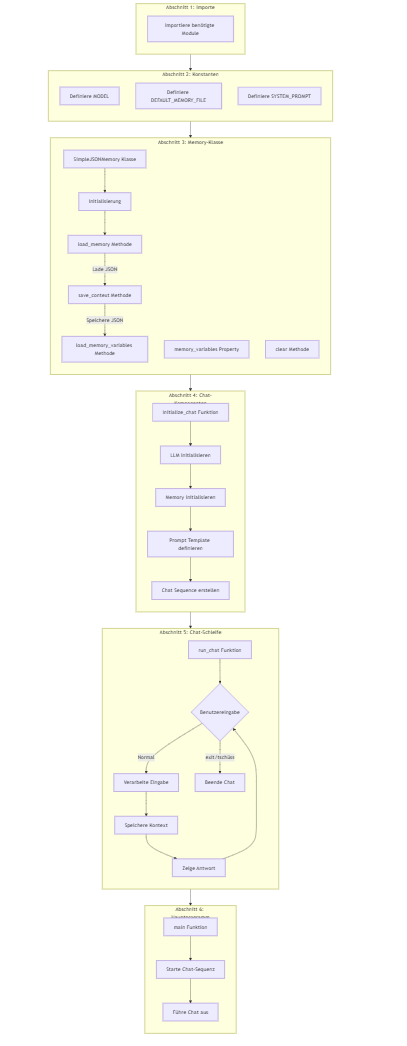

In [ ]:
# Abschnitt 1: Importe
import json
from IPython.display import display, Markdown
from datetime import datetime
from pathlib import Path

from langchain_core.memory import BaseMemory
from langchain_openai import ChatOpenAI
from langchain.prompts import ChatPromptTemplate
from langchain_core.messages import SystemMessage
from langchain_core.runnables import RunnablePassthrough

from pydantic import BaseModel, Field

# Abschnitt 2: Konstanten definieren
MODEL: str = "gpt-4o-mini"
DEFAULT_MEMORY_FILE: str = "chat_memory.json"
SYSTEM_PROMPT: str = """Du bist ein kompetenter KI-Assistent mit breitem Fachwissen.

Deine Antworten sind:
- Klar strukturiert und mit Markdown formatiert
- Praxisorientiert und direkt umsetzbar
- Basierend auf aktuellem Kenntnisstand
- Mit passenden Beispielen versehen
- In verständlicher Sprache formuliert"""

# Abschnitt 3: Memory-Klasse definieren
class SimpleJSONMemory(BaseMemory, BaseModel):
    """Einfache Memory-Implementierung mit JSON-Speicherung."""

    file_path: str = Field(default=DEFAULT_MEMORY_FILE)
    # Corrected type hint for chat_memory
    chat_memory: list[dict[str, str]] = Field(default_factory=list)  # Specify key and value types
    return_messages: bool = Field(default=True)

    def __init__(self, **kwargs) -> None:
        """Initialisiert die Memory-Klasse und lädt existierende Chatverläufe."""
        super().__init__(**kwargs)
        self.chat_memory = self.load_memory()

    def load_memory(self) -> list[dict[str]]:
        """Lädt den Chatverlauf aus der JSON-Datei."""
        try:
            with Path(self.file_path).open("r", encoding='utf-8') as file:
                return json.load(file)
        except FileNotFoundError:
            return []

    def save_context(self, inputs: dict[str], outputs: dict[str, str]) -> None:
        """Speichert den aktuellen Kontext in der JSON-Datei mit Zeitstempel."""
        self.chat_memory.append({
            "timestamp": datetime.now().isoformat(),
            "input": inputs["input"],
            "output": outputs["text"]
        })

        with Path(self.file_path).open("w", encoding='utf-8') as file:
            json.dump(self.chat_memory, file, ensure_ascii=False, indent=2)

    def load_memory_variables(self, inputs: dict[str]) -> dict[str, list[dict[str]]]:
        """Lädt die Chatvariablen für den Prompt."""
        return {"history": self.chat_memory}

    @property
    def memory_variables(self) -> list[str]:
        """Definiert die verfügbaren Memory-Variablen."""
        return ["history"]

    def clear(self) -> None:
        """Implementierung der abstrakten Methode aus BaseMemory.
        Diese Implementierung ist ein Stub und führt keine Aktion aus."""
        pass

# Abschnitt 4: Chat-Komponenten initialisieren
def initialize_chat() -> tuple:
    """Initialisiert die Chat-Komponenten.

    Returns:
        tuple: Chat-Sequence und Memory-Objekt
    """
    # LLM initialisieren
    llm = ChatOpenAI(
        model=MODEL,
        temperature=0.0
    )

    # Memory initialisieren
    memory = SimpleJSONMemory()

    # Prompt Template definieren
    def format_history(history: list[dict[str]]) -> str:
        """Formatiert den Chatverlauf in ein lesbares Format."""
        formatted_history = ""
        for entry in history:
            formatted_history += f"Mensch: {entry['input']}\n"
            formatted_history += f"KI: {entry['output']}\n"
        return formatted_history

    prompt = ChatPromptTemplate.from_messages([
        SystemMessage(content=SYSTEM_PROMPT),
        ("system", "Bisheriger Chatverlauf:\n{history}\n"),
        ("human", "{input}")
    ])

    # Chat Sequence erstellen
    chat_sequence = (
        {
            "history": lambda x: format_history(memory.load_memory_variables({})["history"]),
            "input": lambda x: x["input"]
        }
        | prompt
        | llm
    )

    return chat_sequence, memory

# Abschnitt 5: Chat-Schleife
def run_chat(chat_sequence: RunnablePassthrough, memory: SimpleJSONMemory) -> None:
    """Führt die Chat-Schleife aus. """
    print("Chat gestartet. Zum Beenden 'exit' oder 'tschüss' eingeben.\n")

    while True:
        print()
        user_input = input("\U0001F9B1 Mensch: ")
        if user_input.lower() in ["exit", "tschüss"]:
            break

        response = chat_sequence.invoke({"input": user_input})
        memory.save_context({"input": user_input}, {"text": response.content})

        print(f"\n🤖 KI: ")
        # display(Markdown(response.content)) # Hat zu Problemen in der Kombi mit input() geführt
        print("\nKI:", response.content, "\n")

# Abschnitt 6: Hauptprogramm
def main() -> None:
    """Hauptfunktion zum Starten des Chat-Bots."""
    chat_sequence, memory = initialize_chat()
    run_chat(chat_sequence, memory)

In [ ]:
main()

<p><font color='blue' size="4">
Version: kompletter Chat & Summary m. ConversationSummaryMemory
</font></p>

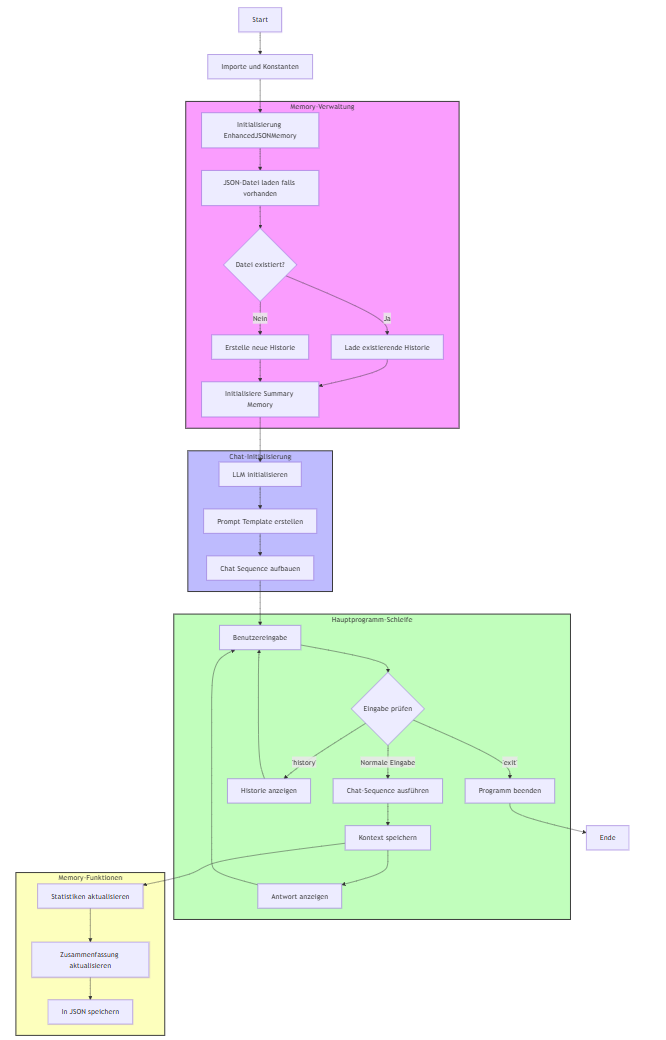

In [ ]:
import json
import os
from datetime import datetime
from pathlib import Path
from langchain_core.memory import BaseMemory
from langchain_openai import ChatOpenAI
from langchain.prompts import ChatPromptTemplate
from langchain_core.messages import SystemMessage
from langchain_core.runnables import RunnablePassthrough
from langchain.memory import ConversationSummaryBufferMemory
from pydantic import BaseModel, Field

# Konstanten
MODEL = "gpt-4-turbo-preview"
DEFAULT_MEMORY_FILE = "chat_memory.json"
SYSTEM_PROMPT = """Du bist ein kompetenter KI-Assistent mit breitem Fachwissen.

Deine Antworten sind:
- Klar strukturiert und mit Markdown formatiert
- Praxisorientiert und direkt umsetzbar
- Basierend auf aktuellem Kenntnisstand
- Mit passenden Beispielen versehen
- In verständlicher Sprache formuliert"""

class EnhancedJSONMemory(BaseMemory, BaseModel):
    """Erweiterte Memory-Implementierung mit JSON-Speicherung, Statistiken und Zusammenfassung."""
    file_path: str = Field(default=DEFAULT_MEMORY_FILE)
    summary_memory: object = Field(default=None)
    chat_data: dict[str, object] = Field(default_factory=lambda: {
        "conversations": [],
        "metadata": {
            "created_at": datetime.now().isoformat(),
            "last_modified": datetime.now().isoformat(),
            "total_interactions": 0,
            "model_name": MODEL,
            "version": "2.0"
        },
        "statistics": {
            "average_response_length": 0,
            "total_chars_exchanged": 0
        },
        "summary": ""
    })

    def __init__(self, **kwargs) -> None:
        """Initialisiert die Memory-Klasse und lädt existierende Chatverläufe."""
        super().__init__(**kwargs)
        self.summary_memory = ConversationSummaryBufferMemory(
            llm=ChatOpenAI(temperature=0, model=MODEL),
            max_token_limit=2000,
            memory_key="summary",
            human_prefix="Mensch",
            ai_prefix="KI"
        )
        self.load_history()

    def format_timestamp(self, timestamp_str: str) -> str:
        """Formatiert einen ISO-Zeitstempel in ein lesbares Format."""
        return datetime.fromisoformat(timestamp_str).strftime("%d.%m.%Y %H:%M:%S")

    def update_statistics(self, user_input: str, response: str) -> None:
        """Aktualisiert die Chatstatistiken."""
        stats = self.chat_data["statistics"]
        total_responses = len(self.chat_data["conversations"])

        if total_responses > 0:
            current_total = stats["average_response_length"] * (total_responses - 1)
            stats["average_response_length"] = round((current_total + len(response)) / total_responses, 2)

        stats["total_chars_exchanged"] += len(user_input) + len(response)

    def update_summary(self, user_input: str, response: str) -> None:
        """Aktualisiert die Konversationszusammenfassung."""
        self.summary_memory.save_context({"input": user_input}, {"output": response})
        self.chat_data["summary"] = self.summary_memory.load_memory_variables({}).get("summary", "")

    def save_context(self, inputs: dict[str], outputs: dict[str, str]) -> None:
        """Speichert den aktuellen Kontext mit erweiterten Metadaten."""
        self.chat_data["conversations"].append({
            "timestamp": datetime.now().isoformat(),
            "user_input": inputs["input"],
            "response": outputs["text"],
            "interaction_id": len(self.chat_data["conversations"]) + 1
        })
        self.chat_data["metadata"]["last_modified"] = datetime.now().isoformat()
        self.chat_data["metadata"]["total_interactions"] += 1

        self.update_statistics(inputs["input"], outputs["text"])
        self.update_summary(inputs["input"], outputs["text"])
        self._save_to_file()

    def _save_to_file(self) -> None:
        """Speichert den Chatverlauf in der JSON-Datei."""
        try:
            with Path(self.file_path).open("w", encoding="utf-8") as file:
                json.dump(self.chat_data, file, ensure_ascii=False, indent=2)
        except Exception as e:
            print(f"⚠️ Fehler beim Speichern der Historie: {str(e)}")

    def load_history(self) -> None:
        """Lädt die Chathistorie aus der JSON-Datei."""
        if not Path(self.file_path).exists():
            return

        try:
            with Path(self.file_path).open("r", encoding="utf-8") as file:
                loaded_data = json.load(file)

            if "metadata" in loaded_data and "version" in loaded_data["metadata"]:
                self.chat_data = loaded_data
                print("✅ Konversationshistorie wurde erfolgreich geladen.")

                # Lade vorhandene Konversationen in das Summary Memory
                for conv in self.chat_data["conversations"]:
                    self.summary_memory.save_context(
                        {"input": conv["user_input"]},
                        {"output": conv["response"]}
                    )
            else:
                print("⚠️ Veraltetes Historienformat erkannt. Erstelle neue Historie.")
        except json.JSONDecodeError as e:
            print(f"⚠️ Fehler beim Laden der JSON-Datei: {str(e)}")

    def load_memory_variables(self, inputs: dict[str]) -> dict[str, list[dict[str]]]:
        """Lädt die Chatvariablen für den Prompt."""
        return {"history": self.chat_data["conversations"], "summary": self.chat_data["summary"]}

    @property
    def memory_variables(self) -> list[str]:
        """Definiert die verfügbaren Memory-Variablen."""
        return ["history", "summary"]

    def clear(self) -> None:
        """Implementierung der abstrakten Methode aus BaseMemory."""
        self.chat_data["conversations"] = []
        self.chat_data["summary"] = ""
        self.summary_memory.clear()

    def show_history(self) -> None:
        """Zeigt eine detaillierte Konversationshistorie und Zusammenfassung."""
        if not self.chat_data["conversations"]:
            print("❌ Keine Konversationshistorie vorhanden.")
            return

        print("\n📊 Chat-Statistiken:")
        stats = self.chat_data["statistics"]
        meta = self.chat_data["metadata"]
        print(f"Gesamtinteraktionen: {meta['total_interactions']}")
        print(f"Durchschnittliche Antwortlänge: {stats['average_response_length']} Zeichen")
        print(f"Gesamter Zeichenaustausch: {stats['total_chars_exchanged']} Zeichen")

        if self.chat_data["summary"]:
            print("\n📝 Zusammenfassung der Konversation:")
            print(self.chat_data["summary"])

        print("\n📜 Detaillierte Konversationshistorie:")
        for conv in self.chat_data["conversations"]:
            print("\n" + "="*50)
            print(f"🔢 Interaktion #{conv['interaction_id']}")
            print(f"🕒 Zeitpunkt: {self.format_timestamp(conv['timestamp'])}")
            print(f"🧑‍🦱 Mensch: {conv['user_input']}")
            print(f"🤖 KI: \n{conv['response']}")

def initialize_chat() -> tuple:
    """Initialisiert die Chat-Komponenten und gibt Chat-Sequence und Memory-Objekt zurück."""
    # LLM und Memory initialisieren
    llm = ChatOpenAI(model=MODEL, temperature=0.0)
    memory = EnhancedJSONMemory()

    # Prompt Template und Chat Sequence erstellen
    prompt = ChatPromptTemplate.from_messages([
        SystemMessage(content=SYSTEM_PROMPT),
        ("system", "Zusammenfassung der bisherigen Konversation:\n{summary}\n"),
        ("system", "Bisheriger Chatverlauf:\n{history}\n"),
        ("human", "{input}")
    ])

    # Hilfsfunktion für Formatierung
    def format_history(history):
        return "\n".join([f"Mensch: {entry['user_input']}\nKI: {entry['response']}" for entry in history])

    # Chat Sequence erstellen
    chat_sequence = (
        {
            "history": lambda x: format_history(memory.load_memory_variables({})["history"]),
            "summary": lambda x: memory.load_memory_variables({})["summary"],
            "input": lambda x: x["input"]
        }
        | prompt
        | llm
    )

    return chat_sequence, memory

def run_chat(chat_sequence, memory) -> None:
    """Führt die Chat-Schleife aus."""
    print("Chat gestartet.\n")
    print("Befehle:\n- 'history': Zeigt die Chathistorie\n- 'exit' oder 'tschüss': Beendet den Chat\n")

    while True:
        user_input = input("\U0001F9B1 Mensch: ")

        if user_input.lower() in ["exit", "tschüss"]:
            break
        elif user_input.lower() == "history":
            memory.show_history()
            continue

        response = chat_sequence.invoke({"input": user_input})
        memory.save_context({"input": user_input}, {"text": response.content})

        print(f"\n🤖 KI: \n{response.content}\n")

def main() -> None:
    """Hauptfunktion zum Starten des Chat-Bots."""
    chat_sequence, memory = initialize_chat()
    run_chat(chat_sequence, memory)

In [ ]:
main()

# **A <font color='orange'>|</font> Aufgabe**
---

Die Aufgabestellungen unten bieten Anregungen, Sie können aber auch gerne eine andere Herausforderung angehen.

<p><font color='black' size="5">
KI-gestütztes Notizbuch mit automatischer Kategorisierung
</font></p>

Entwicklen Sie ein KI-Notizbuch, das Eingaben von Nutzern speichert, automatisch kategorisiert (z. B. "Technologie", "Privat", "Aufgaben") und kontextbezogene Vorschläge liefert. Verwende dazu ein LangChain Memory-Konzept, z.B. ConversationBufferMemory, für eine effiziente Verwaltung.


<p><font color='black' size="5">
Chatbot: Nachrichten- vs. Summary-Speicher
</font></p>

Erstelle einen einfachen Chatbot mit LangChain, der zwischen Nachrichten- und Summary-Speicher unterscheidet. Analysiere, wie sich die Speichertypen auf die Qualität der Antworten auswirken.

<p><font color='black' size="5">
Automatische Protokollerstellung für Meetings
</font></p>

Entwickle ein System, das Gesprächsverläufe speichert und automatisch eine zusammenfassende Chat-Notiz erstellt. Nutze z.B. ConversationSummaryMemory, um die wichtigsten Punkte aus langen Gesprächen zu extrahieren.

<p><font color='black' size="5">
Virtuelle Assistenten mit eigenem Gedächtnis
</font></p>

Eine Datei wird bereitgestellt, die ein Gespräch zwischen zwei virtuellen Assistenten enthält. Jede Antwort soll aus genau einem Satz bestehen. Die Datei ist folgendermaßen aufgebaut:

| Assistent | Eingabe |
|-----------|--------|
| botA      | Ich heiße Max. |
| botB      | Mein Name ist Emma. |
| botA      | Ich wohne in Berlin. |
| botB      | Ich lebe in Hamburg. |
| botA      | Wo wohne ich und wie heiße ich? |
| botB      | Wo lebe ich? |


**Aufgabe**   
Schreiben Sie Programm, das zwei virtuelle Assistenten simuliert, die jeweils ein eigenes Gedächtnis haben. Die Eingaben aus der Datei werden an den jeweiligen Assistenten geschickt, und ihre Antworten sollen in einer neuen Datei gespeichert werden.

**Erwartete Ausgabe**   
Die erwartete Ausgabe könnte wie folgt aussehen:

| Assistent | Antwort |
|-----------|---------|
| botA      | Hallo Max. |
| botB      | Hallo Emma. |
| botA      | Danke für diese Information. |
| botB      | Danke für diese Information. |
| botA      | Hallo Max, du wohnst in Berlin und dein Name ist Max. |
| botB      | Hallo Emma, du lebst in Hamburg. |

**Hinweise**
- Die Antworten müssen nicht exakt mit der Beispielausgabe übereinstimmen, sollten aber sinngemäß ähnlich sein.
- Jeder Assistent hat ein eigenes Gedächtnis und sollte sich nur an seine eigenen Informationen erinnern.
- Das Programm soll die Antworten in einer neuen Datei im gleichen Tabellenformat speichern.

